## Testing nonlinear

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as plt
import pygslib as gslib
%matplotlib inline


In [2]:
help(gslib.nonlinear)

Help on module pygslib.nonlinear in pygslib:

NAME
    pygslib.nonlinear - PyGSLIB nonlinear, Module with function for nonlinear geostatistics

FILE
    /home/adrian/bitbucket/public/pygslib/pygslib/nonlinear.so

DESCRIPTION
    Copyright (C) 2015 Adrian Martinez Vargas 
    
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 3 of the License, or
    any later version.
       
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
       
    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>

FUNCTIONS
    Y2Z(...)
        Y2Z( y, PCI, ypmin,zpmin,ypmax,zpmax,yamin,

## Get some data ready for work

In [3]:
mydata=gslib.read_gslib_file('../datasets/cluster.dat')
print mydata.head()
t=mydata['Primary'].values
w=mydata['Declustering Weight'].values

# if apply declustering make sure to use the declustred mean in all calculation 
parameters_probpltl =  {
        'iwt'  : 1, #int, 1 use declustering weight
        'va'   : t,            
        'wt'   : w}  

# get the mean from pplot function 
binval,cl,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax,xcvr,xmen,xvar,error = gslib.__plot.probplt(**parameters_probpltl)

print 'mean     :', xmen
print 'variance :', xvar

   Xlocation  Ylocation  Primary  Secondary  Declustering Weight
0       39.5       18.5     0.06       0.22                1.619
1        5.5        1.5     0.06       0.27                1.619
2       38.5        5.5     0.08       0.40                1.416
3       20.5        1.5     0.09       0.39                1.821
4       27.5       14.5     0.09       0.24                1.349
mean     : 2.52812132597
variance : 22.0867684812


## Get transformation table

In [4]:
z,y, error = gslib.__dist_transf.anatbl(t,w,despike=1)
print 'there was any error?: ', error!=0

there was any error?:  False


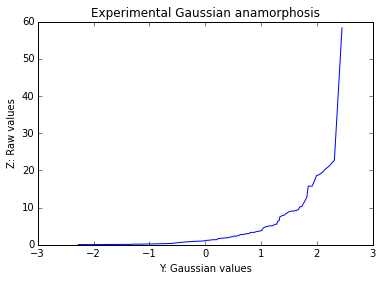

In [5]:
# plot experimental anamorphosis function 
plt.plot(y,z, label='raw or experimental')
plt.xlabel('Y: Gaussian values')
plt.ylabel('Z: Raw values')
plt.title('Experimental Gaussian anamorphosis')
#plt.yscale ('log')
#plt.xscale ('log')
#plt.legend(loc=2)
plt.show()

## Test anamorphosis

/home/adrian/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


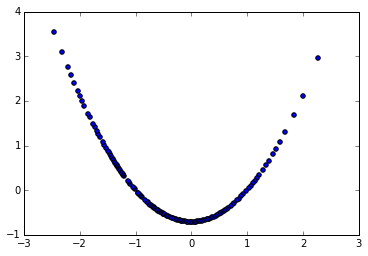

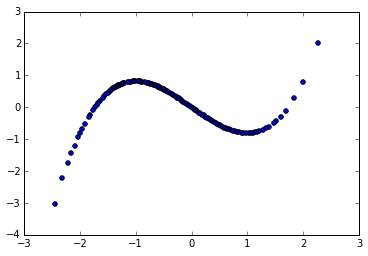

In [6]:
K=50
H=gslib.nonlinear.recurrentH(y=y, K=K)

# some test plot, example lack of correlation
plt.scatter(H[1,:], H[2,:])
plt.show()
plt.scatter(H[1,:], H[3,:])
plt.show()

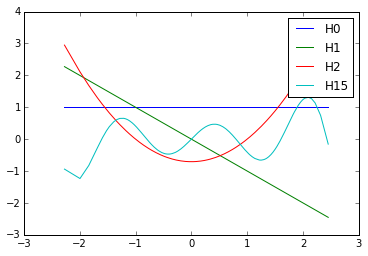

In [7]:
# plot some H values
plt.plot(y,H[0,:], label='H0')
plt.plot(y,H[1,:], label='H1')
plt.plot(y,H[2,:], label='H2')
plt.plot(y,H[15,:], label='H15')
plt.legend()
plt.show()

## Fit Anamaorphosis coefficients

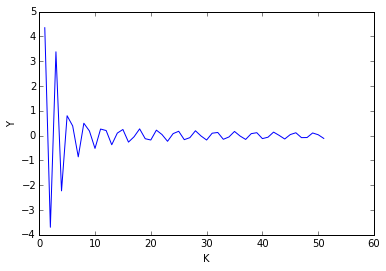

In [8]:


PCI=gslib.nonlinear.fit_PCI(z,y,H, meanz=xmen)
#print PCI
plt.plot(np.arange(PCI.shape[0])+1, PCI)
plt.xlabel('K')
plt.ylabel('Y')
plt.show()


### Validate PCI

There are two basic validations:

 - The variance calculated from PCI may be close to the experimental variance (declustered)
 - The error of the z' fitted with hermite polynomial expansion may be close to z

In [9]:
# test variance
print 'Variance from PCI:                 ', gslib.nonlinear.var_PCI(PCI)
print 'Variance experimental declustered: ', xvar
print 'Variance experimental:             ', np.var(z)

Variance from PCI:                  33.1088227228
Variance experimental declustered:  22.0867684812
Variance experimental:              44.9242522728


Mean z 4.35047885959
Mean ze 5.76721153484
Var z 44.9242522728
Var ze 32.2306152299


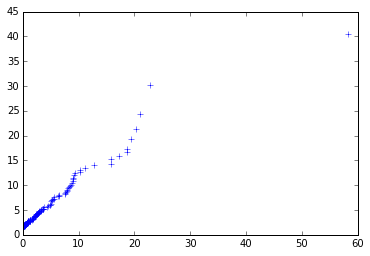

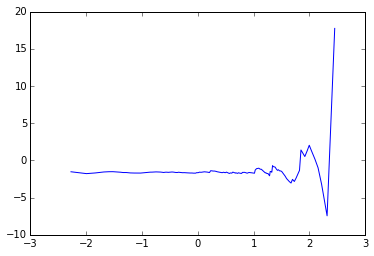

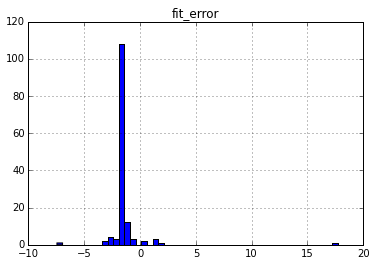

In [10]:
# test the fiiting error with polynomial expansion
ze = gslib.nonlinear.expand_anamor(PCI,H,r=1) # make sure that r == 1 for point support

fit_error = z-ze

#print some comparisons
print 'Mean z', z.mean()
print 'Mean ze', ze.mean()
print 'Var z', z.var()
print 'Var ze', ze.var()

# scaterplots of true / estimate
plt.plot(z,ze, '+')
plt.show()

# error by y
plt.plot(y,fit_error)
plt.show()

# plot histogram of errors
pd.DataFrame({'fit_error': fit_error}).hist(bins=K)
plt.show()


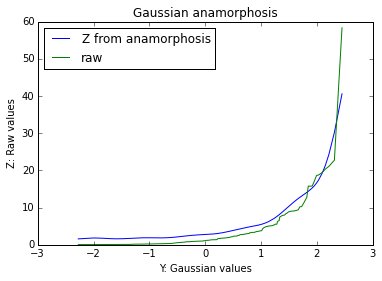

In [11]:
# also plot anamorphosis function 
plt.plot(y,ze,label='Z from anamorphosis')
plt.plot(y,z, label='raw')
plt.xlabel('Y: Gaussian values')
plt.ylabel('Z: Raw values')
plt.title('Gaussian anamorphosis')
plt.legend(loc=2)
plt.show()

<p>
<div class="alert alert-danger">
 ** Warning: ** There is bias if you use declustering, we are investigating this. 
 See the non declusterd example "Anamor not declustered"
</div>

# Using the function to transform arbitrary y values

As result of some nonlinear and simulation application you may have arbitrary gaussian (Y) values you want to convert to raw (Z) values. This is partially implemented and only valid for some practical intervals. 

To do this is necessary to identify four set of control points: 

 - [yamin,zamin] admissible minimum value
 - [ypmin,zpmin] practical minimum value
 - [ypmax,zpmax] practical minimum value
 - [yamax,zamin] admissible minimum value





In [12]:
zamin, yamin, zpmin, ypmin, zpmax, ypmax, zamax, yamax = gslib.nonlinear.ctrpoints(z,y,ze)
print zamin,yamin,zamax,yamax
print zpmin,ypmin,zpmax,ypmax


0.0600345209241 -2.27403211594 58.3200035095 2.45256710052
0.31009671092 -0.77213716507 58.3200035095 2.45256710052


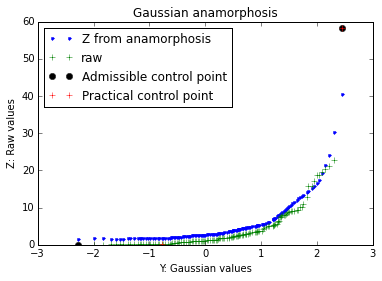

In [13]:
# also plot anamorphosis function 
plt.plot(y,ze,'.', label='Z from anamorphosis')
plt.plot(y,z, '+', label='raw')
plt.plot(yamin,zamin, 'ok', label='Admissible control point')
plt.plot(yamax,zamax, 'ok')
plt.plot(ypmin,zpmin, '+r', label='Practical control point')
plt.plot(ypmax,zpmax, '+r')
plt.xlabel('Y: Gaussian values')
plt.ylabel('Z: Raw values')
plt.title('Gaussian anamorphosis')
plt.legend(loc=2)
plt.show()

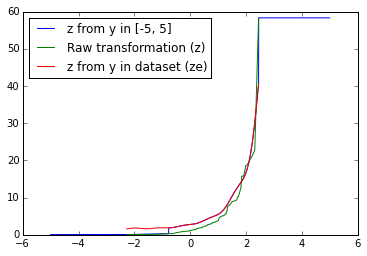

In [14]:
#test using different Y data to fit a new Z (not in the input)
yyy=np.linspace(-5,5,4000)

ZZZ=gslib.nonlinear.Y2Z(yyy,PCI,zamin, yamin, zpmin, ypmin, zpmax, ypmax, zamax, yamax, r=1)

plt.plot(yyy,ZZZ, label = 'z from y in [-5, 5]')
plt.plot(y,z, label = 'Raw transformation (z)')
plt.plot(y,ze, label = 'z from y in dataset (ze)')
plt.legend(loc=2)
plt.show()

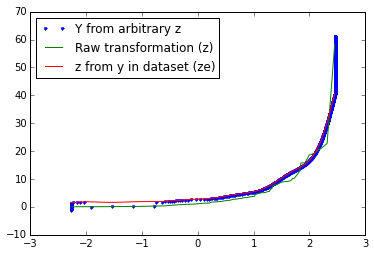

In [15]:
#test using different Z data to fit a new Y 
zzz=np.linspace(z.min()-1,z.max()+3,1000)

YYY=gslib.nonlinear.Z2Y_linear(zzz,ze,y,zamin, yamin, zpmin, ypmin, zpmax, ypmax, zamax, yamax)

plt.plot(YYY,zzz, '.',linewidth=2.0, label = 'Y from arbitrary z')
plt.plot(y,z, label = 'Raw transformation (z)')
plt.plot(y,ze, label = 'z from y in dataset (ze)')
plt.legend(loc=2)
plt.show()

# Change of support and information effect

## Support effect

To account for support effect you need to know: 

- point-support variance:  $Var(Zx) = γ(\infty)$
- block-support variance: $ Var(Zv) = \gamma(\infty) − \gamma(v,v) $

## Information effect

To account for information effect, in addition to the point variance and block variance, you need to know:

- estimated grade variance: $ Var(Zv^*) = Var(Zv) -  \sigma^2_K - 2\mu$
- true grade–estimated grade covariance: $Cov(Zv,Zv^*) = Var(Zv) - \sigma^2_K - \mu$

Note that the information effect has two components. The smoothing due to kriging, represented by the estimated grade variance and some degree of conditional bias represented by the true grade–estimated grade covariance. Note that the amount of conditional bias can be represented as the slope of regression: $p = Cov(Zv,Zv^*) / (Cov(Zv,Zv^*)  - \mu)$


## Calculating the support effect

In [16]:
# first we define the parameters for block covariance calculation
xsize = 5
ysize = 5
zsize = 5
nx, ny, nz = (5, 5, 5) # number of discretization points 
dx = np.linspace(0 + xsize/(2*nx), xsize-xsize/(2*nx), nx)
dy = np.linspace(0 + ysize/(2*ny), ysize-ysize/(2*ny), ny)
dz = np.linspace(0 + zsize/(2*nz), ysize-ysize/(2*nz), nz)
xv, yv, zv = np.meshgrid(dx, dy, dz)
xdb = xv.ravel() 
ydb = yv.ravel() 
zdb = zv.ravel() 

parameters_blk = { 
                'xdb'  :  xdb,       # X coordinates of discretazation points
                'ydb'  :  ydb,       # Y coordinates of discretazation points
                'zdb'  :  zdb,       # Z coordinates of discretazation points
                'it'   :  [1, 1],    # two structures: 1 spherical, 2 exponential 
                'c0'   :  [6],    # nugget,  
                'cc'   :  [10, 10],# variance of each structure 
                'aa'   :  [30, 60],  # parameter a (or range) mayor direction 
                'aa1'  :  [30, 60],  # parameter a (or range) semimayor direction 
                'aa2'  :  [30, 60],   # parameter a (or range) minor direction
                'ang1'   : [0, 0],   # Rotation angles per structure  
                'ang2'   : [0, 0],              
                'ang3'   : [0, 0]}       
      


unbias, blk_var=gslib.__block_covariance.block_covariance(**parameters_blk)

print 'var(Zx)=', blk_var
print 'unbias:', unbias
print 'f:', blk_var/unbias

var(Zx)= 16.979510753
unbias: 26.0
f: 0.653058105883


In [17]:
# now we can calculate r
r = gslib.nonlinear.get_r (Var_Zv=blk_var,PCI= PCI)
print r

0.833818556982


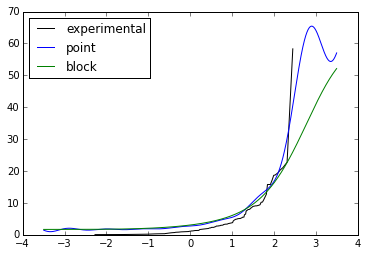

In [18]:
# see the impact in the CDF (this time we plot z from anamorphosis)
yi=np.linspace(-3.5,3.5,4000)
H_yi = gslib.nonlinear.recurrentH(y=yi, K=K)
zp= gslib.nonlinear.expand_anamor(PCI,H=H_yi,r=1) 
zr= gslib.nonlinear.expand_anamor(PCI,H=H_yi,r=r) 

plt.plot(y,z,'k', label = 'experimental')
plt.plot(yi,zp, label = 'point')
plt.plot(yi,zr, label = 'block')

plt.legend(loc=2)
plt.show()

## Calculating information effect parameters

Here we assume some arbitrary numbers. In practice you may do kriging in a panel with dummy future data, for example, blast holes.  

$ \sigma^2_K = 2 $

and 

$ \mu = 0.5 $

Then 

$ Var(Zv^*) = Var(Zv) -  \sigma^2_K - 2\mu$
$ = Var(Zv) -  2 - 1 $

$Cov(Zv,Zv^*) = Var(Zv) - \sigma^2_K - \mu$
$ = Var(Zv) - 2 - 0.5$

In [19]:
blk_e_var= blk_var - 2. -2*0.5
blk_te_covar= blk_var - 2. -0.5
print 'Var(Zv*)=   ', blk_e_var
print 'Cov(Zv,Zv*)=', blk_te_covar

Var(Zv*)=    13.979510753
Cov(Zv,Zv*)= 14.479510753


In [20]:
# now we can calculate s and ro
s = gslib.nonlinear.get_r (Var_Zv=blk_e_var,PCI= PCI)
ro = gslib.nonlinear.get_ro(Covar_ZvZv=blk_te_covar, PCI= PCI, r=r, s=s)
print 'r   = ', r
print 's   = ', s
print 'ro  = ', ro
print 's*ro= ', s*ro

r   =  0.833818556982
s   =  0.783230811357
ro  =  0.961273747303
s*ro=  0.752899217037


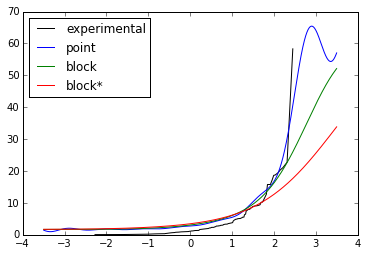

In [21]:
# see the impact in the CDF (this time we plot z from anamorphosis)
zs= gslib.nonlinear.expand_anamor(PCI,H=H_yi,r=s*r) 

plt.plot(y,z,'k', label = 'experimental')
plt.plot(yi,zp, label = 'point')
plt.plot(yi,zr, label = 'block')
plt.plot(yi,zs, label = 'block*') # verify this

plt.legend(loc=2)
plt.show()